In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
# from sklearn.linear_model import LinearRegression
# from sklearn import preprocessing

pd.set_option("display.max_rows", None)
plt.style.use('ggplot')

#用殘插座軍職回歸

# 資料匯入

In [282]:
b = pd.read_csv("D:\\統計套利\\brent.csv")
b = b[['Date', 'Open', 'Price']]
b.columns = ['date', 'open_b', 'close_b']
w = pd.read_csv("D:\\統計套利\\wti.csv")
w = w[['Date', 'Open', 'Price']]
w.columns = ['date', 'open_w', 'close_w']


b['date'] = pd.to_datetime(b['date'])
w['date'] = pd.to_datetime(w['date'])

In [283]:
date = pd.read_csv("D:\\統計套利\\最後結算日.csv", encoding = 'ANSI')
date['西德州最後結算日'] = pd.to_datetime(date['西德州最後結算日'])
date['布蘭特最後結算日'] = pd.to_datetime(date['布蘭特最後結算日'])

date['西德州轉倉日'] = date['西德州最後結算日'] - datetime.timedelta(5)
date['布蘭特轉倉日'] = date['布蘭特最後結算日'] - datetime.timedelta(5)

date = date[['西德州轉倉日', '布蘭特轉倉日']]

In [284]:
data = pd.merge(w, b, on = 'date', how = 'inner')
data = data.dropna().reset_index(drop = True)
# data = data.drop([5115, 5116], axis = 0).reset_index(drop = True)

data['spread'] = data['close_w'] - data['close_b']
data['mean'] = data['spread'].rolling(60).mean()
data['std'] = data['spread'].rolling(60).std()
data['ub'] = data['mean'] + 2* data['std']
data['lb'] = data['mean'] - 2* data['std']

#波動度的叢聚效應
data['fmd'] = data['std'].rolling(7).mean()
data['smd'] = data['std'].rolling(21).mean()


data['spreadd'] = (data['open_w']-data['open_b'])
data['point'] = np.round(data['spreadd'].diff(), 4).shift(-1)

In [243]:
# plt.figure(figsize = (14, 6))

# plt.subplot(2, 1, 1)
# plt.title("Oil Price & Delta")
# plt.plot(data['date'], data['open_w'], color = 'blue')
# plt.plot(data['date'], data['open_b'], color = "orange")
# plt.legend(['WTI', 'Brent'])

# plt.subplot(2, 1, 2)
# plt.plot(data['date'], data['mean'], color = "red")
# plt.plot(data['date'], data['ub'], color = "black")
# plt.plot(data['date'], data['lb'], color = "black")
# # plt.legend(['WTI', 'Brent'])

# plt.show()

In [244]:
# plt.figure(figsize = (14, 6))

# plt.subplot(2, 1, 1)
# plt.plot(data['date'], data['spread'], color = 'black')

# plt.subplot(2, 1, 2)
# plt.plot(data['date'], data['std'])
# plt.plot(data['date'], data['fmd'])
# plt.plot(data['date'], data['smd'])

# plt.show()

# 績效分析

In [285]:
pos = [0]
buy_price = []

for i in range(1, len(data)):
    if pos[-1] == 0:
        if (data.loc[i, 'spread'] > data.loc[i, 'ub']):
            pos.append(-1)
            buy_price.append(data.loc[i+1, 'spreadd'])
        elif (data.loc[i, 'spread'] < data.loc[i, 'lb']):
            pos.append(1)
            buy_price.append(data.loc[i+1, 'spreadd'])
        else:
            pos.append(pos[-1])
            
    elif pos[-1] < 0:
        if data.loc[i, 'spread'] < data.loc[i, 'mean']:
            pos.append(pos[-1] + 1)
#         elif (data.loc[i, 'fmd'] > data.loc[i, 'smd']):
#             pos.append(pos[-1] + 1)
        else :
            pos.append(pos[-1])
    elif pos[-1] > 0:
        if data.loc[i, 'spread'] > data.loc[i, 'mean']:
            pos.append(pos[-1] - 1)
#         elif (data.loc[i, 'fmd'] > data.loc[i, 'smd']):
#             pos.append(pos[-1] - 1)
        else :
            pos.append(pos[-1])
            
data['pos'] = pos
data['pos'] = data['pos'].shift()
data['pos'][0] = 0

C:\Users\internuser1\AppData\Local\Temp\ipykernel_12676\1070954488.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pos'][0] = 0


In [286]:
data['pnl'] = np.nan
fee = 100

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] != 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] != 0):
        #持有部位時須轉倉
        if (data.loc[i, 'date'] in np.array(date['西德州轉倉日'])):
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        elif(data.loc[i, 'date'] in np.array(date['布蘭特轉倉日'])) :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        else :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        
data['pnl'] = (200000 + data['pnl'].cumsum())
data['high'] = data['pnl'].cummax()
data['dd'] =  (data['pnl'] - data['high'])/data['high']

eh = data.drop_duplicates(["high"])

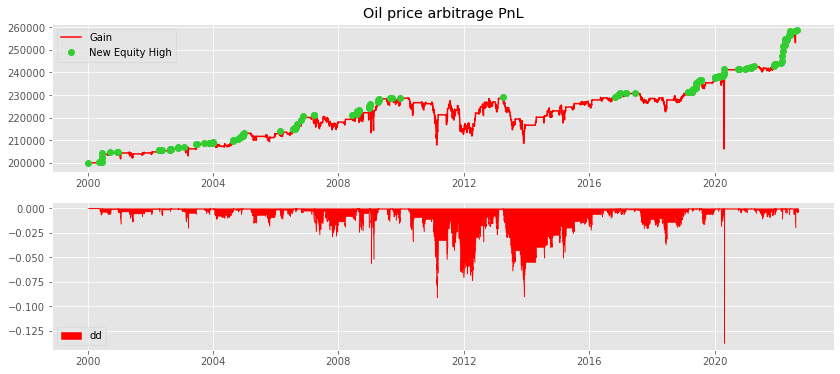

In [287]:
plt.figure(figsize = (14, 6))

plt.subplot(2, 1, 1)
plt.title("Oil price arbitrage PnL")
plt.plot(data['date'], data['pnl'], color = "red")
plt.plot(eh['date'], eh['pnl'], "o", color = "limegreen")
plt.legend(['Gain', 'New Equity High'])

plt.subplot(2, 1, 2)
plt.fill_between(data['date'], data['dd'], interpolate=False, color='red')
plt.legend(['dd'], loc = 'lower left')

plt.show()

# 績效指標

In [248]:
#持倉時間
#總持倉時間/交易比數
#年度獲利

In [279]:
mean = np.mean(data['pnl'].pct_change())*252
s = np.std(data['pnl'].pct_change())*(252**0.5)
sp = np.round(mean/s, 4)

ret = np.round((data.loc[5723, 'pnl']-200000)/200000, 4) *100
mdd = np.round(data.loc[:, 'dd'].min(), 4) *100
rm = np.round(ret/(-mdd), 4)

trade = [200000]
date = ["2000-01-01"]

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0) :
        trade.append(data.loc[i, 'pnl'])
        date.append(data.loc[i, "date"])
        
a = pd.DataFrame(date, columns = ['date'])
a['principal'] = trade
a['pnl'] = a['principal'].diff()

win = 0
loss = 0
w = 0
l = 0

for i in range(2, len(a)):
    if a.loc[i, 'pnl'] > 0 :
        win += 1
        w += a.loc[i, 'pnl']
    elif a.loc[i, 'pnl'] < 0:
        loss += 1
        l += a.loc[i, 'pnl']
        
pf = np.round(w/-l, 4)
times = len(a.loc[1:, :])
win_rate = np.round(win/times, 4)

print("Return: {}%".format(ret) + "\nMDD: {}%".format(-mdd) +"\nReturn to MDD: {}".format(rm)+"\nSharpe Ratio: {}".format(sp) + "\nProfit Factor: {}".format(pf) + "\nWin Rate: {}%".format(win_rate*100)+"\nTimes :{}".format(times))

Return: 28.939999999999998%
MDD: 13.76%
Return to MDD: 2.1032
Sharpe Ratio: 0.2211
Profit Factor: 2.1014
Win Rate: 67.5%
Times :120


C:\Users\internuser1\AppData\Local\Temp\ipykernel_12676\1840231039.py:17: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  a = pd.DataFrame(date, columns = ['date'])


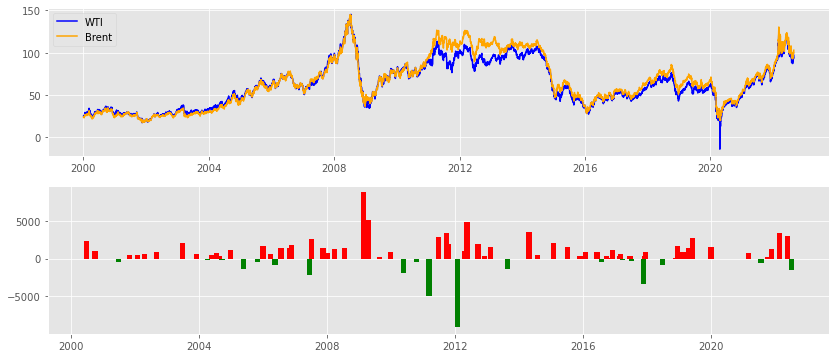

In [250]:
plt.figure(figsize = (14, 6))
plt.title('PnL per Trade', fontsize = 20)


plt.subplot(2, 1, 1)
plt.plot(data['date'], data['open_w'], color = 'blue')
plt.plot(data['date'], data['open_b'], color = "orange")
plt.legend(['WTI', 'Brent'])

plt.subplot(2, 1, 2)
for i in range(1, len(a)):
    if a.loc[i, 'pnl'] > 0:
        plt.bar(a.loc[i, 'date'], a.loc[i, 'pnl'], 60, color = 'red')
        
    elif a.loc[i, 'pnl'] < 0:
        plt.bar(a.loc[i, 'date'], a.loc[i, 'pnl'], 60, color = 'green')
# plt.legend(['gain', 'loss'])

plt.show()

# 純做多

In [251]:
pos = [0]
buy_price = []
d = []

for i in range(1, len(data)):
    if pos[-1] == 0:
        if (data.loc[i, 'spread'] < data.loc[i, 'lb'])& (data.loc[i, 'fmd'] < data.loc[i, 'smd']):
            pos.append(1)
            buy_price.append(data.loc[i+1, 'spreadd'])
        else:
            pos.append(pos[-1])
            
    elif pos[-1] > 0:
        if data.loc[i, 'spread'] > data.loc[i, 'mean']:
            pos.append(pos[-1] - 1)
#         elif (data.loc[i, 'spreadd'] < buy_price[-1] * 0.97):
#             pos.append(pos[-1] - 1)
#             d.append(data.loc[i+1, 'date'])
        else :
            pos.append(pos[-1])
            
data['pos'] = pos
data['pos'] = data['pos'].shift()
data['pos'][0] = 0

C:\Users\internuser1\AppData\Local\Temp\ipykernel_12676\285184681.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pos'][0] = 0


In [252]:
date = pd.read_csv("D:\\統計套利\\最後結算日.csv", encoding = 'ANSI')
date['西德州最後結算日'] = pd.to_datetime(date['西德州最後結算日'])
date['布蘭特最後結算日'] = pd.to_datetime(date['布蘭特最後結算日'])

date['西德州轉倉日'] = date['西德州最後結算日'] - datetime.timedelta(5)
date['布蘭特轉倉日'] = date['布蘭特最後結算日'] - datetime.timedelta(5)

date = date[['西德州轉倉日', '布蘭特轉倉日']]

In [253]:
data['pnl'] = np.nan
fee = 100

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] != 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] != 0):
        #持有部位時須轉倉
        if (data.loc[i, 'date'] in np.array(date['西德州轉倉日'])):
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        elif(data.loc[i, 'date'] in np.array(date['布蘭特轉倉日'])) :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        else :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        
data['pnl'] = (200000 + data['pnl'].cumsum())
data['high'] = data['pnl'].cummax()
data['dd'] =  (data['pnl'] - data['high'])/data['high']

eh = data.drop_duplicates(["high"])

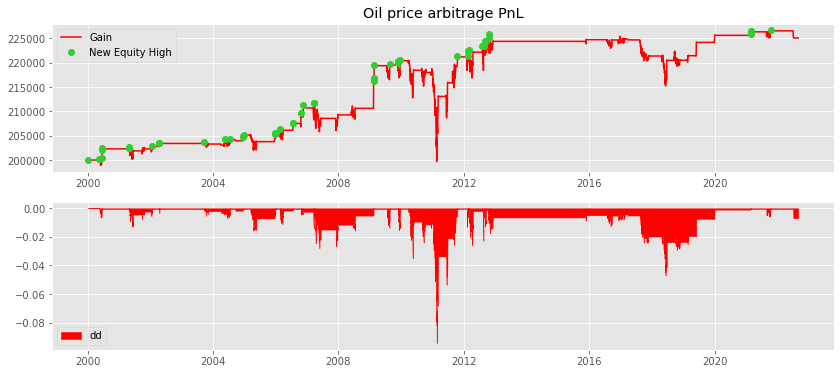

In [254]:
plt.figure(figsize = (14, 6))

plt.subplot(2, 1, 1)
plt.title("Oil price arbitrage PnL")
plt.plot(data['date'], data['pnl'], color = "red")
plt.plot(eh['date'], eh['pnl'], "o", color = "limegreen")
plt.legend(['Gain', 'New Equity High'])

plt.subplot(2, 1, 2)
plt.fill_between(data['date'], data['dd'], interpolate=False, color='red')
plt.legend(['dd'], loc = 'lower left')

plt.show()

In [255]:
mean = np.mean(data['pnl'].pct_change())*252
s = np.std(data['pnl'].pct_change())*(252**0.5)
sp = np.round(mean/s, 4)

ret = np.round((data.loc[5723, 'pnl']-200000)/200000, 4) *100
mdd = np.round(data.loc[:, 'dd'].min(), 4) *100
rm = np.round(ret/(-mdd), 4)

trade = [200000]
date = ["2000-01-01"]

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0) :
        trade.append(data.loc[i, 'pnl'])
        date.append(data.loc[i, "date"])
        
a = pd.DataFrame(date, columns = ['date'])
a['principal'] = trade
a['pnl'] = a['principal'].diff()

win = 0
loss = 0
w = 0
l = 0

for i in range(2, len(a)):
    if a.loc[i, 'pnl'] > 0 :
        win += 1
        w += a.loc[i, 'pnl']
    elif a.loc[i, 'pnl'] < 0:
        loss += 1
        l += a.loc[i, 'pnl']
        
pf = np.round(w/-l, 4)
times = len(a.loc[1:, :])
win_rate = np.round(win/times, 4)

print("Return: {}".format(ret) + "\nMDD: {}".format(-mdd) +"\nReturn to MDD: {}".format(rm)+"\nSharpe Ratio: {}".format(sp) + "\nProfit Factor: {}".format(pf) + "\nWin Rate: {}%".format(win_rate*100)+"\nTimes :{}".format(times))

Return: 12.540000000000001
MDD: 9.44
Return to MDD: 1.3284
Sharpe Ratio: 0.2086
Profit Factor: 2.2522
Win Rate: 65.96%
Times :47


C:\Users\internuser1\AppData\Local\Temp\ipykernel_12676\3352004386.py:17: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  a = pd.DataFrame(date, columns = ['date'])


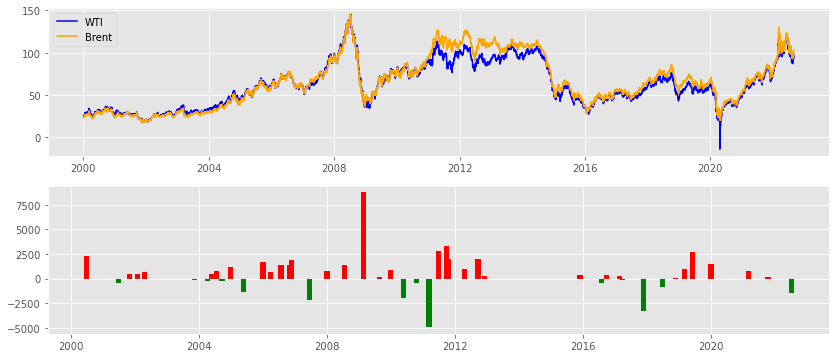

In [256]:
plt.figure(figsize = (14, 6))
plt.title('PnL per Trade', fontsize = 20)


plt.subplot(2, 1, 1)
plt.plot(data['date'], data['open_w'], color = 'blue')
plt.plot(data['date'], data['open_b'], color = "orange")
plt.legend(['WTI', 'Brent'])

plt.subplot(2, 1, 2)
for i in range(1, len(a)):
    if a.loc[i, 'pnl'] > 0:
        plt.bar(a.loc[i, 'date'], a.loc[i, 'pnl'], 60, color = 'red')
        
    elif a.loc[i, 'pnl'] < 0:
        plt.bar(a.loc[i, 'date'], a.loc[i, 'pnl'], 60, color = 'green')
# plt.legend(['gain', 'loss'])

plt.show()

# 純做空

In [257]:
pos = [0]
buy_price = []

for i in range(1, len(data)):
    if pos[-1] == 0:
        if (data.loc[i, 'spread'] > data.loc[i, 'ub'])& (data.loc[i, 'fmd'] < data.loc[i, 'smd']) :
            pos.append(-1)
            buy_price.append(data.loc[i+1, 'spreadd'])
        else:
            pos.append(pos[-1])
            
    elif pos[-1] < 0:
        if data.loc[i, 'spread'] < data.loc[i, 'mean']:
            pos.append(pos[-1] + 1)
#         elif data.loc[i, 'spread'] < buy_price[-1] * 1.03:
#             pos.append(pos[-1] + 1)
        else :
            pos.append(pos[-1])

data['pos'] = pos
data['pos'] = data['pos'].shift()
data['pos'][0] = 0

C:\Users\internuser1\AppData\Local\Temp\ipykernel_12676\3459410301.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pos'][0] = 0


In [258]:
date = pd.read_csv("D:\\統計套利\\最後結算日.csv", encoding = 'ANSI')
date['西德州最後結算日'] = pd.to_datetime(date['西德州最後結算日'])
date['布蘭特最後結算日'] = pd.to_datetime(date['布蘭特最後結算日'])

date['西德州轉倉日'] = date['西德州最後結算日'] - datetime.timedelta(5)
date['布蘭特轉倉日'] = date['布蘭特最後結算日'] - datetime.timedelta(5)

date = date[['西德州轉倉日', '布蘭特轉倉日']]

In [259]:
data['pnl'] = np.nan
fee = 100

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] != 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] != 0):
        #持有部位時須轉倉
        if (data.loc[i, 'date'] in np.array(date['西德州轉倉日'])):
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        elif(data.loc[i, 'date'] in np.array(date['布蘭特轉倉日'])) :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        else :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        
data['pnl'] = (200000 + data['pnl'].cumsum())
data['high'] = data['pnl'].cummax()
data['dd'] =  (data['pnl'] - data['high'])/data['high']

eh = data.drop_duplicates(["high"])

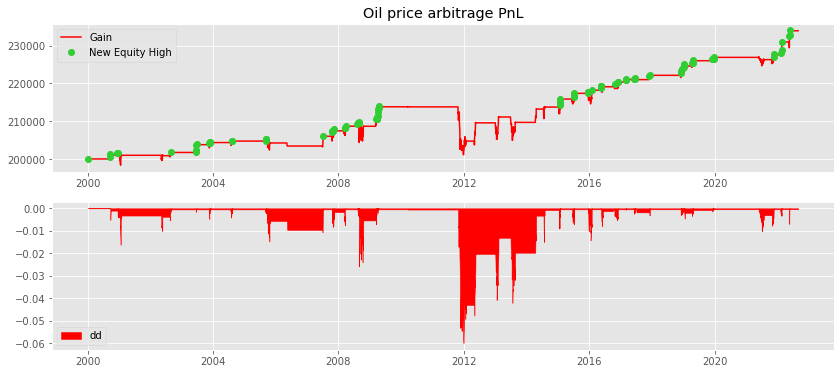

In [260]:
plt.figure(figsize = (14, 6))

plt.subplot(2, 1, 1)
plt.title("Oil price arbitrage PnL")
plt.plot(data['date'], data['pnl'], color = "red")
plt.plot(eh['date'], eh['pnl'], "o", color = "limegreen")
plt.legend(['Gain', 'New Equity High'])

plt.subplot(2, 1, 2)
plt.fill_between(data['date'], data['dd'], interpolate=False, color='red')
plt.legend(['dd'], loc = 'lower left')

plt.show()

In [261]:
mean = np.mean(data['pnl'].pct_change())*252
s = np.std(data['pnl'].pct_change())*(252**0.5)
sp = np.round(mean/s, 4)

ret = np.round((data.loc[5723, 'pnl']-200000)/200000, 4) *100
mdd = np.round(data.loc[:, 'dd'].min(), 4) *100
rm = np.round(ret/(-mdd), 4)

trade = [200000]
date = ["2000-01-01"]

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0) :
        trade.append(data.loc[i, 'pnl'])
        date.append(data.loc[i, "date"])
        
a = pd.DataFrame(date, columns = ['date'])
a['principal'] = trade
a['pnl'] = a['principal'].diff()

win = 0
loss = 0
w = 0
l = 0

for i in range(2, len(a)):
    if a.loc[i, 'pnl'] > 0 :
        win += 1
        w += a.loc[i, 'pnl']
    elif a.loc[i, 'pnl'] < 0:
        loss += 1
        l += a.loc[i, 'pnl']
        
pf = np.round(w/-l, 4)
times = len(a.loc[1:, :])
win_rate = np.round(win/times, 4)

print("Return: {}".format(ret) + "\nMDD: {}".format(-mdd) +"\nReturn to MDD: {}".format(rm)+"\nSharpe Ratio: {}".format(sp) + "\nProfit Factor: {}".format(pf) + "\nWin Rate: {}%".format(win_rate*100)+"\nTimes :{}".format(times))

Return: 16.96
MDD: 5.9799999999999995
Return to MDD: 2.8361
Sharpe Ratio: 0.3704
Profit Factor: 3.5654
Win Rate: 72.5%
Times :40


C:\Users\internuser1\AppData\Local\Temp\ipykernel_12676\3352004386.py:17: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  a = pd.DataFrame(date, columns = ['date'])


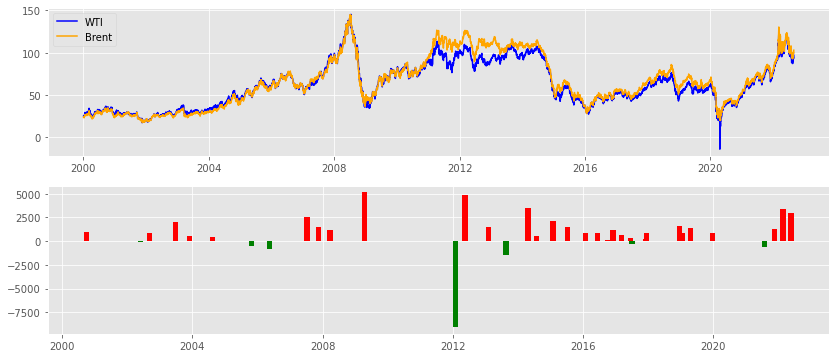

In [262]:
plt.figure(figsize = (14, 6))
plt.title('PnL per Trade', fontsize = 20)


plt.subplot(2, 1, 1)
plt.plot(data['date'], data['open_w'], color = 'blue')
plt.plot(data['date'], data['open_b'], color = "orange")
plt.legend(['WTI', 'Brent'])

plt.subplot(2, 1, 2)
for i in range(1, len(a)):
    if a.loc[i, 'pnl'] > 0:
        plt.bar(a.loc[i, 'date'], a.loc[i, 'pnl'], 60, color = 'red')
        
    elif a.loc[i, 'pnl'] < 0:
        plt.bar(a.loc[i, 'date'], a.loc[i, 'pnl'], 60, color = 'green')
# plt.legend(['gain', 'loss'])

plt.show()

# 資料切分&清洗

In [263]:
# model = LinearRegression(fit_intercept=True)

# x = np.array(train['ret_w']).reshape((-1, 1))
# y = np.array(train['ret_b'])

# model.fit(x, y)
# # Print the Intercept:
# print('intercept:', model.intercept_)

# # Print the Slope:
# print('slope:', model.coef_) 

In [264]:
# #樣本外
# test = data[data['date'] >= "2020-01-01"]
# test['delta'] = test['open_w'] - test['open_b']
# test['point'] = np.round(test['delta'] - test['delta'].shift(), 4).shift(-1)

# # mean = np.mean(test['ret_w'])
# # std = np.std(test['ret_w'])
# # test = test[(test['ret_w'] < mean+3*std) & (test['ret_w'] > mean-3*std)].reset_index(drop = True)

In [265]:
# test['prediction'] = model.intercept_ + model.coef_*test['ret_b']
# test['residual'] = (preprocessing.normalize([test['ret_b'] - test['prediction']])).reshape(676, 1)

In [266]:
# test['mean_r'] = test['residual'].rolling(20).mean()
# test['std_r'] = test['residual'].rolling(20).std()

# test['ub'] = test['mean_r'] + 2*test['std_r']
# test['ubb'] = test['mean_r'] + 1*test['std_r']
# test['lb'] = test['mean_r'] - 2*test['std_r']
# test['lbb'] = test['mean_r'] - 1*test['std_r']

# test = test.dropna().reset_index(drop = True)

In [267]:
# plt.figure(figsize = (14, 6))

# plt.title("Oil Price & Delta")
# plt.plot(test['date'], test['residual'], color = 'r')
# plt.plot(test['date'], test['ubb'], color = 'blue')
# plt.plot(test['date'], test['lbb'], color = 'blue')
# plt.plot(test['date'], test['ub'], color = 'black')
# plt.plot(test['date'], test['lb'], color = 'black')

# plt.show()

# 策略績效

In [268]:
# pos = [0]

# for i in range(1, len(test)):
    
#     if pos[-1] == 0:
#         #空單進場訊號
#         if test.loc[i, 'residual'] > test.loc[i, 'ub']:
#             pos.append(-1)
#         #多單進場訊號
#         elif test.loc[i, 'residual'] < test.loc[i, 'lb']:
#             pos.append(1)
#         #沒有訊號時
#         else :
#             pos.append(0)
#     #空單平倉訊號
#     elif pos[-1] == (-1):
#         if test.loc[i, 'residual'] < test.loc[i, 'ubb']:
#             pos.append(pos[-1]+1)
#         else :
#             pos.append(pos[-1])
#     #多單平倉訊號
#     elif pos[-1] == (1):
#         if test.loc[i, 'residual'] > test.loc[i, 'lbb']:
#             pos.append(pos[-1]-1)
#         else :
#             pos.append(pos[-1])
            
# test['pos'] = pos
# test['pos'] = test['pos'].shift()
# test['pos'][0] = 0

In [269]:
# date = pd.read_csv("D:\\統計套利\\最後結算日.csv", encoding = 'ANSI')
# date['西德州最後結算日'] = pd.to_datetime(date['西德州最後結算日'])
# date['布蘭特最後結算日'] = pd.to_datetime(date['布蘭特最後結算日'])

# date['西德州轉倉日'] = date['西德州最後結算日'] - datetime.timedelta(5)
# date['布蘭特轉倉日'] = date['布蘭特最後結算日'] - datetime.timedelta(5)

# date = date[['西德州最後結算日', '西德州轉倉日', '布蘭特最後結算日', '布蘭特轉倉日']]

In [270]:
# test['pnl'] = np.nan
# fee = 100

# for i in range(1, len(test)):
#     if (test.loc[i-1, 'pos'] == 0) & (test.loc[i, 'pos'] == 0):
#         test.loc[i, 'pnl'] = (test.loc[i, 'pos'] * test.loc[i, 'point'])*1000
#     elif (test.loc[i-1, 'pos'] == 0) & (test.loc[i, 'pos'] != 0):
#         test.loc[i, 'pnl'] = (test.loc[i, 'pos'] * test.loc[i, 'point'])*1000 - fee
#     elif (test.loc[i-1, 'pos'] != 0) & (test.loc[i, 'pos'] != 0):
#         #持有部位時須轉倉
#         if (test.loc[i, 'date'] in np.array(date['西德州轉倉日'])) or (test.loc[i, 'date'] in np.array(date['布蘭特轉倉日'])):
#             test.loc[i, 'pnl'] = (test.loc[i, 'pos'] * test.loc[i, 'point'])*1000 - 2*fee
#         else :
#             test.loc[i, 'pnl'] = (test.loc[i, 'pos'] * test.loc[i, 'point'])*1000
#     elif (test.loc[i-1, 'pos'] != 0) & (test.loc[i, 'pos'] == 0):
#         test.loc[i, 'pnl'] = (test.loc[i, 'pos'] * test.loc[i, 'point'])*1000 - fee
        
# test['pnl'] = test['pnl'].cumsum()
# test['high'] = test['pnl'].cummax()
# test['dd'] =  test['pnl'] - test['high']

In [271]:
# eh = test.drop_duplicates(["high"])

In [272]:
# plt.figure(figsize = (14, 6))

# plt.subplot(2, 1, 1)
# plt.title("Oil price arbitrage PnL")
# plt.plot(test['date'], test['pnl'], color = "red")
# plt.plot(eh['date'], eh['pnl'], "o", color = "limegreen")
# plt.legend(['Gain', 'New Equity High'])

# plt.subplot(2, 1, 2)
# plt.fill_between(test['date'], test['dd'], interpolate=False, color='red')
# plt.legend(['dd'], loc = 'lower left')

# plt.show()